## Idée d'application

On va essayer de poser les bases d'une application permettant de proposer des **alternatives à un produit alimentaire**. Ces alternatives doivent être meilleures pour la santé.

In [1]:
import pandas as pd
import missingno as msno
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

In [2]:
data = pd.read_csv('en.openfoodfacts.org.products.csv', sep="\t")

/home/ilyes/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (0,8,13,27,28,29,31,38,52,55,64,75,77) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Introduction

In [3]:
print("La base de données de Open Food Facts contient:\n- %d produits" % len(data))
print("- %d colonnes" % len(data.columns))
# La clé primaire est 'code', on l'utilise pour détecter les doublons
# nb_doublons: Va contenir le nombre de doublons dans data
nb_doublons = len(data)-len(data.drop_duplicates(subset=['code']))
print("- %d doublons" % nb_doublons)
print("- %d valeurs vides" % (len(data)-data['code'].count()))

La base de données de Open Food Facts contient:
- 1908859 produits
- 186 colonnes
- 270 doublons
- 0 valeurs vides


# Nettoyage préliminaire

## Supression des doublons

In [4]:
data = data.drop_duplicates(subset=['code'])

## Correction des erreurs de casse

In [5]:
cols_categs = ['main_category_en', 'pnns_groups_2', 'pnns_groups_1']

In [6]:
for col_categ in cols_categs:
    data[col_categ] = data[col_categ].str.lower()
data['countries_en'] = data['countries_en'].str.lower()

## Correction des noms de colonnes

In [7]:
data.columns = data.columns.str.lower()

On enlève les tirets au début des noms de colonnes:

In [8]:
# sans_tiret_dep: Fonction enlevant le tiret au début d'un string s'il y en à.
sans_tiret_dep = lambda x: x[1:] if re.search("^-", x) else x
# On applique cette fonction aux noms de colonnes de data.
data.columns = data.columns.map(sans_tiret_dep)

## Premiers filtrages des données

On s'intéresse uniquement aux pays dont on a les catégories.

In [9]:
# data: Va contenir les pays dont on a les catégories en anglais.
data = data.dropna(subset=['categories_en'])
print("Il y à %d produits dont on a la catégorie" % len(data))
# Lorsqu'il y à le caractère ':' dans un champ de 'categories_en', alors une catégorie n'est pas en anglais
data = data[~data['categories_en'].str.contains(":")]
print("On a les catégories en anglais pour %d d'entre eux" % len(data))

Il y à 901345 produits dont on a la catégorie
On a les catégories en anglais pour 812217 d'entre eux


On veux aussi les codes barre des produits

In [10]:
data = data.dropna(subset=['code'])
print("Il y à %d produits dont on a le code barre" % len(data))

Il y à 812217 produits dont on a le code barre


Sélections les colonnes pour lesquelles au moins 30% des données remplies.

In [11]:
# data_count: Résultat de la méthode count appliquée à data
data_count = data.count()
# cols_few_data: Colonnes remplies pour moins de 30% des individus
cols_few_data = data_count[data_count < int(len(data)/3)].index
print("%d colonnes contiennent moins de %d données" % (len(cols_few_data), int(len(data)/3)))
# On supprime ces colonnes de data
data = data.drop(columns=cols_few_data)
print("Colonnes restantes et quantité de données associées")
print(data_count.drop(labels=cols_few_data).sort_values())

131 colonnes contiennent moins de 270739 données
Colonnes restantes et quantité de données associées
brand_owner                                283210
quantity                                   297951
additives_tags                             318689
additives_en                               318689
image_ingredients_small_url                356418
image_ingredients_url                      356418
image_nutrition_small_url                  357208
image_nutrition_url                        357208
fiber_100g                                 385743
serving_quantity                           397338
serving_size                               400971
ecoscore_grade_fr                          411063
ecoscore_score_fr                          411063
nova_group                                 509024
image_url                                  515775
image_small_url                            515775
ingredients_that_may_be_from_palm_oil_n    545276
ingredients_text                           545276

On remarque qu'on a trop peu de données en ce qui concerne la proportion de fruits et légumes pour la colonne ait été gardée. Cependant, même si c'est trop complexe pour le faire ici, une solution aurait pu être d'extraire ces information de la liste textuelle des ingrédients.

## Correction des types des colonnes
Toutes les colonnes finissant par '_100g', ainsi que certaines autres ont des valeurs flottantes. Toutes les autres contiennent des chaînes de caractères.

In [12]:
# cols_quantity: Colonnes des valeurs nutritionnelles
cols_quantity = data.columns[data.columns.str.match('.+_100g$')]
# cols_quantity2: Autres colonnes quantitatives
cols_quantity2 = pd.Index(['additives_n', 'ingredients_from_palm_oil_n', 'ecoscore_score_fr', 
                           'serving_quantity', 'nova_group'])
# cols_quantity: Concatétation de toutes les colonnes quantitatives étudiées
cols_quantity = cols_quantity.append(cols_quantity2)
# Cast en flottant des variables quantitatives
for col_quantity in cols_quantity:
    data[col_quantity] = data[col_quantity].astype(float)
# cols_quality: Colonnes des variables qualitatives
cols_quality = data.columns[~data.columns.isin(cols_quantity)]

for col_quality in cols_quality:
    # Cast en string des variables qualitatives
    data[col_quality] = data[col_quality].astype(str)
    # On vérifie qu'il n'y à pas d'erreurs de casse
    data[col_quality] = data[col_quality].str.lower()

## Suppression des valeurs aberrantes

### Valeurs nutritionnelles

Les valeurs nutritionnelles sont remplies pour 100g de produits. Chacun des comosant doit donc avoir une quantité comprise en 0 et 100g.

In [13]:
# cols_100g: Colonnes des variables nutritionnelles /100g
cols_100g = data.columns[data.columns.str.match('.+_100g$')]
# not_in_100g: Colonnes des variables qui ne sont pas des quantité physiques
not_in_100g = ['nutrition-score-fr_100g', 'energy_100g', 'energy-kcal_100g', 'serving_quantity']
cols_100g = cols_100g.difference(pd.Index(not_in_100g))
# len_data: Taille de data avant suppression des valeurs aberrantes
len_data = len(data)
# col: Un nom de colonne dans cols_100g
for col in cols_100g:
    # Sélection des quantités entre 0 et 100g et les quantités non-définies
    data = data[((data[col] >= 0.) & (data[col] <= 100.))| data[col].isna()]
print("%d produits ont des valeurs nutritionnelles aberrantes" % (len_data-len(data)))

443 produits ont des valeurs nutritionnelles aberrantes


### Valeurs énergétiques

Tous les produits n'ayant aucune valeur énergétique ne peuvent contenir de sucres, de gras, de protéïnes ou de fibres. Les produits dont les valeurs sont incohérentes sont supprimés.

In [14]:
# cond1 : Vraie si le produit a une valeur énergétique non négligeable
cond1 = data['energy-kcal_100g'] > 1
# cond2: Vraie si le produit ne contient pas de gras, de sucre, de protéïnes, de fibres alimentaires ou de carbohydrates.
cond2 = (data['sugars_100g'] == 0.) & (data['fat_100g'] == 0.) & (data['proteins_100g'] == 0.)
cond2 = cond2 & (data['fiber_100g'] == 0.) & (data['carbohydrates_100g'] == 0)
print("%d produits ont des valeurs énergétiques aberrantes" % len(data[cond1 & cond2]))
# On supprime les produits vérifiant les 2 conditions citées ci-dessus.
data = data[~(cond1 & cond2)]

568 produits ont des valeurs énergétiques aberrantes


In [15]:
# cond1 : Vraie si le produit a une valeur énergétique nulle
cond1 = data['energy-kcal_100g'] == 0
# cond2: Vraie si le produit contient du gras, du sucre, des protéïnes, des fibres alimentaires ou des carhbohydrates.
cond2 = (data['sugars_100g'] > 0.) | (data['fat_100g'] > 0.) | (data['proteins_100g'] > 0.)
cond2 = cond2 | (data['fiber_100g'] > 0.) | (data['carbohydrates_100g'] > 0.)
print("%d produits ont des valeurs énergétiques aberrantes" % len(data[cond1 & cond2]))
# On supprime les produits vérifiant les 2 conditions citées ci-dessus.
data = data[~(cond1 & cond2)]

3728 produits ont des valeurs énergétiques aberrantes


Tous les aliments contenant plus de 1000 kcal pour 100g sont aussi supprimés car ils dépassent la concentration calorique maximale possibles (huiles ~ 900kcal/100g)

In [16]:
len_data = len(data)  # On enregistre la taille de la base de données pour voir la différence après filtrage
# kcal_max_100g: Concentration calorique maximale
kcal_max_100g = 1000  
# On garde les valeurs caloriques inférieures au maximum ou les valeurs caloriques non définies
data = data[(data['energy-kcal_100g'] < kcal_max_100g) | (data['energy-kcal_100g'].isna())]
print("%d produits dépassent la limite de concentration calorique possible" % (len_data-len(data)))

891 produits dépassent la limite de concentration calorique possible


### Quantité servie
Les quantités servies ne peuvent être nulles, ni dépasser une certaine valeur. Les produits les plus lourds sont généralement les packs de liquides, qui sont autour de 10kg. Pour prendre une limite large, on choisi arbitrairement 20kg.

In [17]:
len_data = len(data)  # On enregistre la taille de la base de données pour voir la différence après filtrage
# poids_limite: Poid maximal d'un produit accepté en g
poids_limite = 20000
# On garde les produits de poids inférieur au maximum et les poids non définis
data = data[(data['serving_quantity']<poids_limite) | data['serving_quantity'].isna()]
print("%d produits dépassent un poid de %.1fkg" % (len_data-len(data), poids_limite/1000))

26 produits dépassent un poid de 20.0kg


### Nutri-score

Les nutri-scores doivent être compris entre 40 et -15. Éliminons les produits sortants de cet intervalle.

In [18]:
# min_ns, max_ns: On définit le minimum et le maximum du nutri-score
min_ns, max_ns = -15, 40
# cond_nutriscore: Vrai si le produit sort de l'intervalle dans lequel est définit le nutri-score
cond_nutriscore = (data['nutrition-score-fr_100g'] < min_ns) | (data['nutrition-score-fr_100g'] > max_ns)
print("%d produits ont un nutri-score en dehors des bornes [%d, %d]" % (len(data[cond_nutriscore]), min_ns, max_ns))
# On garde les nutriscores dans les bornes définies ou les nutriscores non définis
data = data[(~cond_nutriscore) | data['nutrition-score-fr_100g'].isna()]

0 produits ont un nutri-score en dehors des bornes [-15, 40]


### Ecoscore

Les ecoscores doivent être compris entre -30 et 100. Éliminons les produits sortants de cet intervalle.

In [19]:
# cond_ecoscore: Vrai si le produit sort de l'intervalle dans lequel est définit l'ecoscore
cond_ecoscore = (data['ecoscore_score_fr'] < -30) | (data['ecoscore_score_fr'] > 100)
print("%s produits ont un ecoscore en dehors de [%d, %d]" % (len(data[cond_nutriscore]), -30, 100))
# On garde les écoscores dans les bornes définies et les écoscore non-définis
data = data[(~cond_ecoscore) | data['ecoscore_score_fr'].isna()]

0 produits ont un ecoscore en dehors de [-30, 100]


### Catégories principales

Certains noms de catégories utilisent des tirets au lieu des espaces. On va rectifier cela.

In [20]:
# col_categ: Va contenir le nom de chaque colonne contenant un niveau de catégories
for col_categ in cols_categs:
    # On remplace les caractères '-' par des ' ' dans les les noms de catégories
    data[col_categ] = data[col_categ].str.replace('-', ' ')

Les catégories principales peuvent avoir des noms sans aucun sens. On garde celles qui sont écrites en alphabet latin.

In [21]:
# col_categ: Va contenir le nom de chaque colonne contenant un niveau de catégories
for col_categ in cols_categs:
    len_data = len(data)  # On enregistre la taille de la base de données pour voir la différence après filtrage
    # On garde les noms de colonnes écrits en alphabet latin
    data = data[data[col_categ].str.match('[a-z]+')]
    print("%d catégories dans %s ne sont pas écrites en alphabet latin" % (len_data-len(data), col_categ))

531 catégories dans main_category_en ne sont pas écrites en alphabet latin
0 catégories dans pnns_groups_2 ne sont pas écrites en alphabet latin
0 catégories dans pnns_groups_1 ne sont pas écrites en alphabet latin


Voyons la répartition des effectifs selon la catégorie principale.

Text(0.5, 1.0, 'Effectifs par catégorie principale')

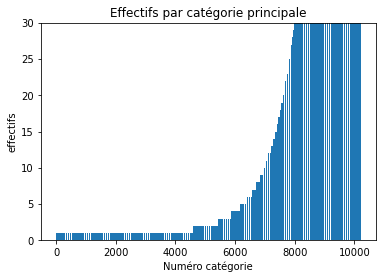

In [22]:
# size_main_categs: Taille de l'effectif pour chaque catégorie principale
size_main_categs = data.groupby('main_category_en').count()['code'].sort_values()
# num_categ: Numéro attribué à chaque catégorie principale
num_categ = [i for i in range(len(size_main_categs))]
# On affiche l'histogramme des effectifs par catégorie principale
plt.bar(num_categ, size_main_categs)
plt.ylim(0, 30)
plt.xlabel('Numéro catégorie')
plt.ylabel('effectifs')
plt.title("Effectifs par catégorie principale")

On observe qu'il y à plusieurs milliers de catégories qui ne contiennent qu'un seul produit. On va donc supprimer ceux qui n'appartiennent à aucune catégorie supérieure.

In [23]:
# categs_low: Catégories ne contenant qu'un seul produit
categs_low = size_main_categs[size_main_categs==1].index
len_data = len(data)  # On enregistre la taille de la base de données pour voir la différence après filtrage
# On garde les produits dont la catégorie principale contient au moins 2 produits, et appartient à une catégorie supérieure
data = data[~(data['main_category_en'].isin(categs_low) & (data['pnns_groups_2'] == 'unknown'))]
print("%d produits sont seuls dans leurs catégories" % (len_data-len(data)))

2529 produits sont seuls dans leurs catégories


### Nova group

In [24]:
len_data = len(data) # On enregistre la taille de la base de données pour voir la différence après filtrage
# cond_nova_group: Vrai si le produit sort de l'intervalle dans lequel est définit le groupe nova
cond_nova_group = (data['nova_group'].isin([float(i) for i in range(1,5)]))
# On garde les écoscores dans les bornes définies et les écoscore non-définis
data = data[cond_nova_group | data['nova_group'].isna()]
print("%s produits ont un groupe nova en dehors de [%d; %d]" % (len_data-len(data), 1., 4.))

0 produits ont un groupe nova en dehors de [1; 4]


### Additives_en

In [25]:
data['additives_en'] = data['additives_en'].str.replace('es:potassium iodide', 'e917 - potassium iodate')

In [26]:
data = data[~data['additives_en'].str.contains(':')]

# Imputation
On va sélectionner les colonnes avec le plus de valeurs manquantes pour les remplir. Ensuite, on testera plusieurs imputers pour remplir les données. Notamment:
- knn (classification ou régression)
- Arbre de décision
- Régression linéaire bayesienne

## Valeurs nutritionnelles

Pour les valeurs nutritionnelles, voyons si les colonnes sont complètes.

<AxesSubplot:>

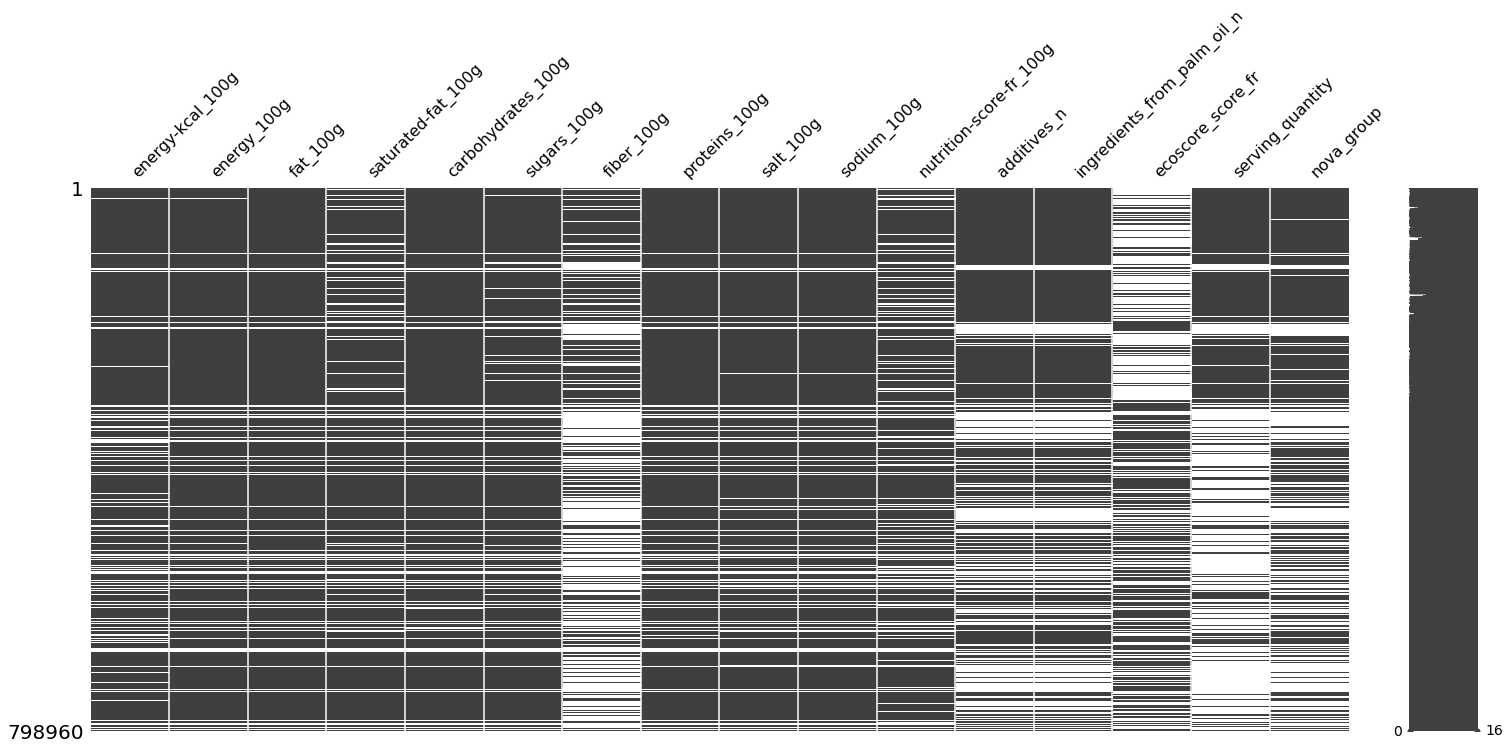

In [27]:
msno.matrix(data[cols_quantity])

In [28]:
# cols_to_impute: Colonnes qu'on veut remplir avec un k-nn
cols_to_impute = pd.Index(['fiber_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'ecoscore_score_fr',
                          'serving_quantity', 'nova_group'])
print("Les %d colonnes pour lesquelles on a le moins de données:" % len(cols_to_impute))
print(data.count()[cols_to_impute].sort_values())

Les 6 colonnes pour lesquelles on a le moins de données:
fiber_100g                     380437
serving_quantity               391650
ecoscore_score_fr              403831
nova_group                     500935
additives_n                    535911
ingredients_from_palm_oil_n    535911
dtype: int64


In [29]:
# cols_quality: Les colonnes des variables qualitatives
cols_quality = pd.Index(['main_category_en', 'pnns_groups_1', 'pnns_groups_2', 'additives_en'])

In [30]:
# On supprime la colonne 'energy_100g' car on a déjà une colonne pour la valeur énergétique
cols_quantity = cols_quantity.difference(pd.Index(['energy_100g']))
# cols_quantity_full: Colonnes dont on va exiger la complétude des données
cols_quantity_full = cols_quantity.difference(cols_to_impute)
# On garde dans data les lignes pour lesquelles on a toutes ces données
data = data.dropna(subset=cols_quantity_full)

### Fonctions d'imputation

On implémente plusieurs fonctions d'imputation, qu'on va tester pour chacune des variables à imputer et dont on gardera la plus performante pour chacune.

In [31]:
def calculate_r2(y_obs, y_exp):
    """Calcule le R2 à partir de la somme des carrés résiduelle et la somme des carrés totale"""
    residual = ((y_obs-y_exp)**2).sum()
    residual = residual / (((y_exp-y_exp.mean())**2).sum())
    return 1-residual

In [32]:
def calculate_error_regressor(reg, xtest, ytest, integers):
    """Calcule 1-R2 pour une prédiction après conversion en valeurs entières si besoin"""
    ytest_calc = reg.predict(xtest)
    if integers:
        ytest_calc = pd.Series(ytest_calc).map(round)
    return 1 - calculate_r2(ytest_calc, ytest)

In [33]:
def regression_imputer_sub(var_name, data_reg, cols_reg, regressor, train_size=0.8, integers=False):
    """Calcule la régression avec de nouvelles conditions initiales"""
    # var_values: Données attendues en sortie
    var_values = data_reg[var_name]
    data_reg = data_reg[cols_reg]
    # On initialise l'échantillon d'entraînement et l'échantillon de test
    xtrain, xtest, ytrain, ytest = train_test_split(data_reg, var_values, train_size=train_size)
    reg = regressor()
    reg.fit(xtrain, ytrain)
    error = calculate_error_regressor(reg, xtest, ytest, integers)
    return reg, error

def regression_imputer(var_name, data, cols_reg, regressor, train_size=0.8, integers=False, nb_trials=5):
    """Entraîne un modèle prédictif sur des données, retourne ce modèle et affiche le 1 - R2"""
    # data_reg: Données qui vont être utilisée en entrée de la régression
    data_reg = data.dropna(subset=cols_reg.append(pd.Index([var_name])))
    print("On a %d individus pour créer la régression de la variable \'%s\'" % (len(data_reg), var_name))
    reg, error = regression_imputer_sub(var_name, data_reg, cols_reg, regressor, train_size, integers)
    print("Regression utilisée: %s" % reg)
    for i in range(nb_trials-1):
        reg_, error_ = regression_imputer_sub(var_name, data_reg, cols_reg, regressor, train_size, integers)
        if error_ < error:
            reg, error = reg_, error_
    print("1 - R^2 = %f " % error)
    return reg

In [113]:
def knn_imputer_sub(data_knn, var_values, k, train_size, knn_construct, integers, nb_trials=5):
    """Calcule le k-nn plusieurs fois, car il dépend des conditions initiales"""
    xtrain, xtest, ytrain, ytest = train_test_split(data_knn, var_values, train_size=train_size)
    knn = knn_construct(n_neighbors=k)
    knn.fit(xtrain, ytrain)
    error = calculate_error_regressor(knn, xtest, ytest, integers)
    for i in range(nb_trials):
        xtrain, xtest, ytrain, ytest = train_test_split(data_knn, var_values, train_size=train_size)
        knn_ = knn_construct(n_neighbors=k)
        knn_.fit(xtrain, ytrain)
        error_ = calculate_error_regressor(knn_, xtest, ytest, integers)
        if error_ < error:
            knn, error = knn_, error_
    return knn, error

def knn_imputer(var_name, data, cols_knn, k_range, train_size=0.8, classifier=True, plot=True, integers=False,
               nb_trials=5):
    """Affiche le graphe des 1 - R2 pour les k-nn en fonction de k et retourne le k-nn optimal trouvé"""
    # knn_construct: Constructeur du knn. Peut être un classifieur ou un régresseur.
    knn_construct = neighbors.KNeighborsClassifier if classifier else neighbors.KNeighborsRegressor
    # data_knn: Données qui vont être utilisée en entrée du k-nn
    data_knn = data.dropna(subset=cols_knn.append(pd.Index([var_name])))
    # var_values: Données attendues en sortie
    var_values = data_knn[var_name]
    data_knn = data_knn[cols_knn]
    # On initialise l'échantillon d'entraînement et l'échantillon de test
    xtrain, xtest, ytrain, ytest = train_test_split(data_knn, var_values, train_size=train_size)
    print("On a %d individus pour créer le k-nn de la variable \'%s\'" % (len(data_knn), var_name))
    # values_k, errors_k, knn: On stocke les résultats de chaque itérations dans ces tableaux
    values_k, errors_k, knns = [], [], []
    for k in range(k_range[0], k_range[1]+1):
        knn = knn_construct(n_neighbors=k)
        knn.fit(xtrain, ytrain)
        error = calculate_error_regressor(knn, xtest, ytest, integers)
        values_k.append(k)
        errors_k.append(error)
        knns.append(knn)
    # Affichage du graphe de l'erreur en fonction de k
    if plot:
        plt.plot(values_k, errors_k)
        plt.xlabel('k')
        plt.ylabel('1 - R^2')
        plt.title("Recherche du k minimisant l\'erreur pour \'%s\'" % var_name)
    # Affichage de l'erreur minimale
    err_min = min(errors_k)
    ind_min = errors_k.index(err_min)
    k_min = values_k[ind_min]
    knn, err_min = knn_imputer_sub(data_knn, var_values, k_min, train_size, knn_construct, integers, nb_trials)
    print("Erreur minimale: %f (k=%d)" % (err_min, k_min))
    return knn

In [35]:
def means_imputer(var_name, data, train_size=0.8, integers=False):
    """ Retourne une fonction qui remplit les valeurs manquantes d'une variable avec la moyenne de la catégorie
    la plus proche pour cette variable"""
    # Création des échantillons de calcul et de test
    data_var = data.dropna(subset=[var_name])
    values_var = data_var[var_name]
    xtrain, xtest, ytrain, ytest = train_test_split(data_var, values_var, train_size=0.8)
    xtrain[var_name] = ytrain
    # Calcul des moyennes niveau de catégorie
    mean_glob = xtrain[var_name].mean()
    mean_per_categ = xtrain.groupby('main_category_en').mean()[var_name]
    mean_per_pnns2 = xtrain.groupby('pnns_groups_2').mean()[var_name]
    mean_per_pnns1 = xtrain.groupby('pnns_groups_1').mean()[var_name]
    # Fonction modifiant la valeur de la variable pour un individu par la moyenne de la catégorie la plus proche
    def impute_individual(x):
        if x['main_category_en'] in mean_per_categ.index:
            x[var_name] = mean_per_categ[x['main_category_en']]
        elif (x['pnns_groups_2'] != 'unknown') and (x['pnns_groups_2'] in mean_per_pnns2.index):
            x[var_name] = mean_per_pnns2[x['pnns_groups_2']]
        elif (x['pnns_groups_1'] != 'unknown') and (x['pnns_groups_1'] in mean_per_pnns1.index):
            x[var_name] = mean_per_pnns1[x['pnns_groups_1']]
        else:
            x[var_name] = mean_glob
        return x
    # On teste cette fonction
    xtest[var_name] = [np.nan]*len(ytest)
    ytest_calc = xtest.apply(impute_individual, axis=1)[var_name]
    if integers:
        ytest_calc = ytest_calc.map(round)
    error = 1 - calculate_r2(ytest_calc, ytest) 
    print("1 - R^2 = %.2f en utilisant les moyennes par catégorie pour %s" % (error, var_name))
    def impute_all(x_all):
        return np.array([impute_individual(x) for x in x_all])
    impute_individual.predict = impute_all
    return impute_individual


### additives_n

Pour cette variable, on a une variable complémentaire qui est 'additives_en'. Elle est moins remplie que la colonne qu'on veut remplir, mais peut-être que les deux colonnes ne sont pas remplies pour les mêmes individus.

In [36]:
def additives_number(additives_list):
    """Compte le nombre d'additifs à partir de la liste des additifs sous forme de chaîne de caractères"""
    if additives_list == 'nan':
        return 0
    else:
        return len(additives_list.split('-'))
# size_additives_n: Nombre de valeurs remplies dans la colonne 'additives_n', pour comparer après remplissage
size_additives_n = len(data['additives_n'].dropna())
# additives_n_calc: Les nombres d'additifs obtenus avec les listes
additives_n_calc = data['additives_en'].map(additives_number)
# On prend le maximum des deux nombres d'additifs pour chaque produit
data['additives_n'] = data['additives_n'].combine(additives_n_calc, max)
print("%d Valeurs du nombre d'additifs ajoutés" % (len(data['additives_n'].dropna())-size_additives_n))

0 Valeurs du nombre d'additifs ajoutés


On va tester différents imputers et comparer leurs précisions.

On a 411997 individus pour créer le k-nn de la variable 'additives_n'
Erreur minimale: 0.234525 (k=50)


KNeighborsRegressor(n_neighbors=50)

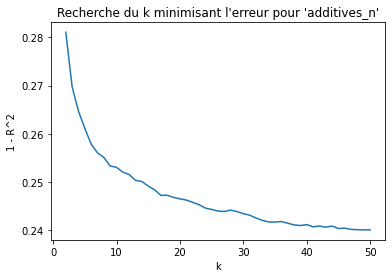

In [114]:
knn_imputer('additives_n', data, cols_quantity_full, (2, 50), plot=True, classifier=False,
            integers=True)

In [38]:
imputer_additives = regression_imputer('additives_n', data, cols_quantity_full, BayesianRidge, integers=True)

On a 411997 individus pour créer la régression de la variable 'additives_n'
Regression utilisée: BayesianRidge()
1 - R^2 = 0.191329 


In [39]:
regression_imputer('additives_n', data, cols_quantity_full, DecisionTreeRegressor, integers=True)

On a 411997 individus pour créer la régression de la variable 'additives_n'
Regression utilisée: DecisionTreeRegressor()
1 - R^2 = 0.288694 


DecisionTreeRegressor()

Voyons ce que l'on obtient comme erreur si on utilise la moyenne par catégorie principale au lieu d'un knn.

In [40]:
means_imputer('additives_n', data, integers=True)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 0.61 en utilisant les moyennes par catégorie pour additives_n


<function __main__.means_imputer.<locals>.impute_individual(x)>

Finalement la méthode la plus précise est celle de la régression k-nn, avec un R2 de ~0.5. C'est une approximation assez peu précise malheureusement. Mais cela peut-être du au fait qu'on n'essaye pas de prédire la quantité d'additifs, mais leurs nombres, et donc il n'y à peut-être pas de lien direct avec les quantités nutritionnelles.

### ingredients_from_palm_oil_n

On a 411997 individus pour créer le k-nn de la variable 'ingredients_from_palm_oil_n'
Erreur minimale: 0.020949 (k=20)


KNeighborsClassifier(n_neighbors=20)

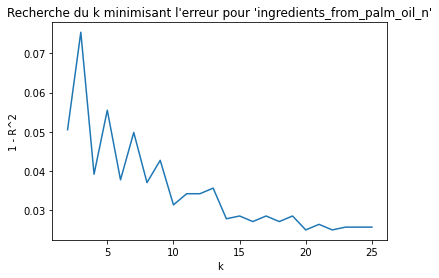

In [115]:
knn_imputer('ingredients_from_palm_oil_n', data, cols_quantity_full, (2,25), 
            classifier=True, integers=True)

In [43]:
imputer_palm_oil = regression_imputer('ingredients_from_palm_oil_n', data, cols_quantity_full, BayesianRidge,
                                      integers=True)

On a 411997 individus pour créer la régression de la variable 'ingredients_from_palm_oil_n'
Regression utilisée: BayesianRidge()
1 - R^2 = 0.005688 


In [44]:
regression_imputer('ingredients_from_palm_oil_n', data, cols_quantity_full, DecisionTreeRegressor,
                   integers=True)

On a 411997 individus pour créer la régression de la variable 'ingredients_from_palm_oil_n'
Regression utilisée: DecisionTreeRegressor()
1 - R^2 = 0.131273 


DecisionTreeRegressor()

In [45]:
means_imputer('ingredients_from_palm_oil_n', data, integers=True)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 1.03 en utilisant les moyennes par catégorie pour ingredients_from_palm_oil_n


<function __main__.means_imputer.<locals>.impute_individual(x)>

### ecoscore_score_fr

On a 293540 individus pour créer le k-nn de la variable 'ecoscore_score_fr'
Erreur minimale: 0.035631 (k=20)


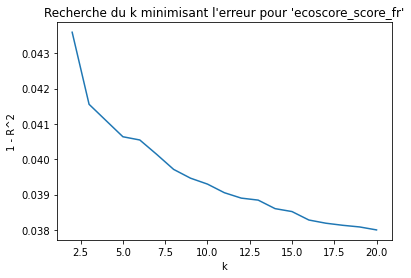

In [116]:
imputer_ecoscore = knn_imputer('ecoscore_score_fr', data, cols_quantity_full, (2,20), classifier=False,
                               integers=True)

In [47]:
regression_imputer('ecoscore_score_fr', data, cols_quantity_full, BayesianRidge,
                   integers=True)

On a 293540 individus pour créer la régression de la variable 'ecoscore_score_fr'
Regression utilisée: BayesianRidge()
1 - R^2 = 0.025926 


BayesianRidge()

In [48]:
regression_imputer('ecoscore_score_fr', data, cols_quantity_full, DecisionTreeRegressor, integers=True)

On a 293540 individus pour créer la régression de la variable 'ecoscore_score_fr'
Regression utilisée: DecisionTreeRegressor()
1 - R^2 = 0.044033 


DecisionTreeRegressor()

In [49]:
means_imputer('ecoscore_score_fr', data, integers=True)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 0.12 en utilisant les moyennes par catégorie pour ecoscore_score_fr


<function __main__.means_imputer.<locals>.impute_individual(x)>

### fiber_100g

On a 338798 individus pour créer le k-nn de la variable 'fiber_100g'
Erreur minimale: 0.318705 (k=4)


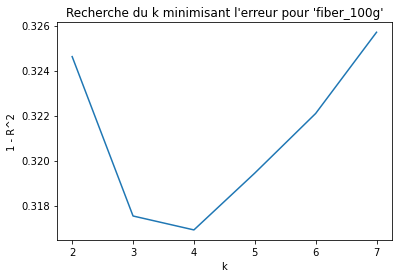

In [117]:
imputer_fiber = knn_imputer('fiber_100g', data, cols_quantity_full, (2,7), classifier=False)

In [51]:
regression_imputer('fiber_100g', data, cols_quantity_full, BayesianRidge)

On a 338798 individus pour créer la régression de la variable 'fiber_100g'
Regression utilisée: BayesianRidge()
1 - R^2 = 0.700073 


BayesianRidge()

In [52]:
regression_imputer('fiber_100g', data, cols_quantity_full, DecisionTreeRegressor)

On a 338798 individus pour créer la régression de la variable 'fiber_100g'
Regression utilisée: DecisionTreeRegressor()
1 - R^2 = 0.414722 


DecisionTreeRegressor()

In [53]:
means_imputer('fiber_100g', data)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 0.58 en utilisant les moyennes par catégorie pour fiber_100g


<function __main__.means_imputer.<locals>.impute_individual(x)>

### serving_quantity

On a 311328 individus pour créer le k-nn de la variable 'serving_quantity'
Erreur minimale: 0.456407 (k=10)


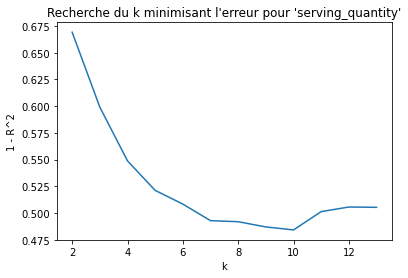

In [118]:
imputer_serving_quantity = knn_imputer('serving_quantity', data, cols_quantity_full, (2,13), classifier=False)

In [55]:
regression_imputer('serving_quantity', data, cols_quantity_full, BayesianRidge)

On a 311328 individus pour créer la régression de la variable 'serving_quantity'
Regression utilisée: BayesianRidge()
1 - R^2 = 0.725168 


BayesianRidge()

In [56]:
regression_imputer('serving_quantity', data, cols_quantity_full, DecisionTreeRegressor)

On a 311328 individus pour créer la régression de la variable 'serving_quantity'
Regression utilisée: DecisionTreeRegressor()
1 - R^2 = 0.774383 


DecisionTreeRegressor()

In [57]:
means_imputer('serving_quantity', data)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 0.47 en utilisant les moyennes par catégorie pour serving_quantity


<function __main__.means_imputer.<locals>.impute_individual(x)>

### nova_group

On a 388670 individus pour créer le k-nn de la variable 'nova_group'
Erreur minimale: 0.493813 (k=7)


KNeighborsClassifier(n_neighbors=7)

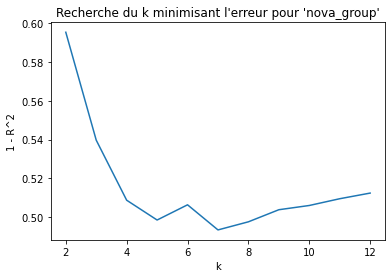

In [119]:
knn_imputer('nova_group', data, cols_quantity_full, (2,12), classifier=True)

On a 387861 individus pour créer le k-nn de la variable 'nova_group'
Erreur minimale: 0.379317 (k=4)


KNeighborsClassifier(n_neighbors=4)

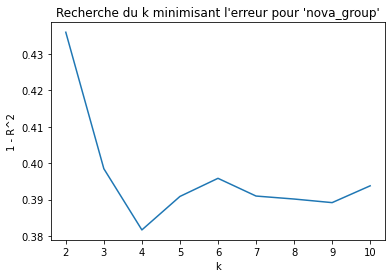

In [120]:
knn_imputer('nova_group', data,
            cols_quantity_full.append(pd.Index(['additives_n', 'ingredients_from_palm_oil_n'])),
            (2,10), classifier=True)

In [71]:
imputer_nova_group = regression_imputer('nova_group', data, cols_quantity_full, DecisionTreeClassifier, integers=True)

On a 388670 individus pour créer la régression de la variable 'nova_group'
Regression utilisée: DecisionTreeClassifier()
1 - R^2 = 0.217066 


In [61]:
regression_imputer('nova_group', data,
                   cols_quantity_full.append(pd.Index(['additives_n', 'ingredients_from_palm_oil_n'])),
                   DecisionTreeClassifier, integers=True)

On a 387861 individus pour créer la régression de la variable 'nova_group'
Regression utilisée: DecisionTreeClassifier()
1 - R^2 = 0.215642 


In [62]:
means_imputer('nova_group', data, integers=True)

/tmp/ipykernel_11804/3937997819.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtrain[var_name] = ytrain
/tmp/ipykernel_11804/3937997819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xtest[var_name] = [np.nan]*len(ytest)


1 - R^2 = 0.60 en utilisant les moyennes par catégorie pour nova_group


<function __main__.means_imputer.<locals>.impute_individual(x)>

On enregistre les imputers retenus dans un dictionnaire.

In [121]:
# imputers: Dictionnaire des imputers pour chaque colonne à imputer.
imputers={
    'additives_n': imputer_additives,
    'ingredients_from_palm_oil_n': imputer_palm_oil,
    'ecoscore_score_fr': imputer_ecoscore,
    'fiber_100g': imputer_fiber,
    'serving_quantity': imputer_serving_quantity,
    'nova_group': imputer_nova_group
}

In [122]:
has_int_values={
    'additives_n': True,
    'ingredients_from_palm_oil_n': True,
    'ecoscore_score_fr': True,
    'fiber_100g': False,
    'serving_quantity': False,
    'nova_group': True
}

In [131]:
limits = {
    'additives_n': (0, data['additives_n'].max()*2),
    'ingredients_from_palm_oil_n': (0, data['ingredients_from_palm_oil_n'].max()*2),
    'ecoscore_score_fr': (-30, 100),
    'fiber_100g': (0, 100),
    'serving_quantity': (0, 20000),
    'nova_group': (1, 4)
}

In [132]:
def set_in_bounderies(bounderies, x):
    if not (bounderies[0] is None):
        x = max(bounderies[0], x)
    if not (bounderies[1] is None):
        x = min(bounderies[1], x)
    return x

### Utilisation des imputers

In [133]:
data_imputed = data.copy()

In [134]:
imputer_types = [BayesianRidge, neighbors.KNeighborsRegressor, neighbors.KNeighborsClassifier,
                 DecisionTreeClassifier, DecisionTreeRegressor]

In [135]:
def impute(imputer, cols_imputer, var_name, data):
    """Etant donné un imputer, les données en entrée/sortie, remplie les valeurs manquantes d'une colonne"""
    data_empty = data[data[var_name].isna()]
    if not data_empty.empty:  # S'il y à des données manquantes
        if type(imputer) in imputer_types:
            prediction = imputer.predict(data_empty[cols_imputer])
        else:
            prediction = imputer.predict(data_empty[cols_imputer.append(cols_quality)])
        prediction = pd.Series(prediction, index=data_empty.index)
        set_limits = lambda x: set_in_bounderies(limits[var_name], x)
        prediction = prediction.map(set_limits)
        if has_int_values[var_name]:
            prediction = prediction.map(round)
        var_values = data[~data[var_name].isna()][var_name]
        data[var_name] = prediction.append(var_values)

On impute chacune des variables pour lesquelles c'est nécessaire.

In [136]:
# var_name: Nom de la variable à imputer.
for var_name in cols_to_impute:
    impute(imputers[var_name], cols_quantity_full, var_name, data_imputed)

## Résultats du nettoyage

On supprime le reste des individus avec des valeurs manquantes.

In [137]:
data_ = data.dropna(subset=cols_quantity)
data_imputed = data_imputed.dropna(subset=cols_quantity)
print("Au final, on a une base de données complète pour %d individus pour les variables traitées" % len(data_))
print("Avec imputation, la base de données contient %d individus" % len(data_imputed))

Au final, on a une base de données complète pour 70299 individus pour les variables traitées
Avec imputation, la base de données contient 590357 individus


In [138]:
data_imputed.to_csv("data_cleaned_imputed.csv", sep='\t')